In [1]:
import numpy as np
import pandas as pd

from tqdm import tqdm

from scipy.stats import pearsonr
from scipy.stats import ttest_1samp
from scipy.interpolate import interp1d
from scipy.optimize import minimize, differential_evolution


from sklearn.metrics import r2_score

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def f(x, t, z, tau, delta, sigma=1):
    term1 = 1/np.sqrt(2 * np.pi * sigma**2 * (t-tau))
    term2 = -(x - z - delta * (t-tau))**2 / (2 * sigma**2 * (t-tau))
    return term1 * np.exp(term2)

def psi(b, db, t, z, tau, delta, sigma=1):
    term1 = 0.5*f(b(t), t, z, tau, delta, sigma)
    term2 = db(t) - delta - (b(t) - z - delta * (t-tau))/(t-tau)
    return term1 * term2

def fpt(ub, lb, dub, dlb, delta, z=0, sigma=1, dt=0.01, T_max=5):
    gu = [0]
    gl = [0]
    T = [0]
    
    gu.append(-2*psi(ub, dub, dt, z, 0, delta, sigma))
    gl.append( 2*psi(lb, dlb, dt, z, 0, delta, sigma))
    T.append(dt)
    
    for n in range(2, int(T_max/dt)+2):
        su = -2 * psi(ub, dub, n*dt, z, 0, delta, sigma)
        sl =  2 * psi(lb, dlb, n*dt, z, 0, delta, sigma)
        
        for j in range(1, n):
            if ub(j*dt) == 0:
                continue
            
            psi_n_j_pp = psi(ub, dub, n*dt, ub(j*dt), j*dt, delta, sigma)
            psi_n_j_pn = psi(ub, dub, n*dt, lb(j*dt), j*dt, delta, sigma)
            psi_n_j_np = psi(lb, dlb, n*dt, ub(j*dt), j*dt, delta, sigma)
            psi_n_j_nn = psi(lb, dlb, n*dt, lb(j*dt), j*dt, delta, sigma)
            
            su +=  2 * dt * (gu[j] * psi_n_j_pp + gl[j] * psi_n_j_pn)
            sl += -2 * dt * (gu[j] * psi_n_j_np + gl[j] * psi_n_j_nn)
            
        gu.append(su)
        gl.append(sl)
        T.append(n*dt)
        
    gu = np.asarray(gu)
    gl = np.asarray(gl)
    T = np.asarray(T)
    
    gtu = interp1d(T, gu)
    gtl = interp1d(T, gl)
    return gtu, gtl

In [3]:
def CDDM_likelihood(prms, RT, Contrast, Z):
    ub = lambda t: prms[0] * np.exp(-prms[1]*t)
    lb = lambda t: -1*ub(t)
    dub = lambda t: -prms[1] * prms[0] * np.exp(-prms[1]*t)
    dlb = lambda t: -1*dub(t)

    delta0 = prms[2]
    delta1 = prms[3]
    t0 = prms[4]
    sig = prms[5]
    
    T_max = np.max(np.abs(RT))
    gtup, gtlp = fpt(ub, lb, dub, dlb, 0, z=0, dt=0.05, T_max=T_max)
    
    ll = 0
    for i in range(len(RT)):
        if np.abs(RT[i])-t0 > 0:
            
            delta = delta0 - delta1*np.log(Contrast[i])
            
            ll += 0.5*(np.log(Z[i]) - np.log(t0) + 0.5*sig**2)**2/sig**2 + 0.5*np.log(2*np.pi*sig**2*Z[i]**2)
            
            if RT[i]>=0:
                exp_term = np.exp(delta*ub(np.abs(RT[i])-t0) - 0.5*delta**2*(np.abs(RT[i])-t0))
                density = exp_term*gtup(np.abs(RT[i])-t0)
            else:                
                exp_term = np.exp(delta*lb(np.abs(RT[i])-t0) - 0.5*delta**2*(np.abs(RT[i])-t0))
                density = exp_term*gtlp(np.abs(RT[i])-t0)
                
            if density>1e-14:
                ll += -np.log(density)
            else:
                ll += -np.log(1e-14) 
        else:
            ll += -np.log(1e-14)
    
    return ll

In [4]:
data = pd.read_csv('../../_Data/Study1.csv', 
                   index_col=0).reset_index(drop=True)

data = data[data.condition == 'accuracy'].reset_index(drop=True)

data['rt']/=1000
data['Duration']/=1000

In [5]:
prms_dc = {'sbj':[],
           'b0':[],
           'lambda':[],
           'delta0':[],
           'delta1':[],
           't0':[],
           'sigma':[],
           'mean_z':[],
           'std_z':[],
           'G2':[],
           'BIC':[]}

min_b0 = 0.5
max_b0 = 4

min_lambda = .01
max_lambda = 2

min_ndt = 0.05
max_ndt = 1

min_delta0 = -3
max_delta0 = 5

min_delta1 = -3
max_delta1 = 5

min_sig = 0.01
max_sig = 2

In [6]:
for sbj in tqdm(data.participant.unique()):
    sbj_data = data[data['participant']==sbj]
    choice = 2*sbj_data.correct.values.astype(np.int64)-1
    RT = choice*sbj_data.rt.values
    Contranst = sbj_data.contrast.values
    Z = sbj_data.rt.values-sbj_data.Duration.values

    min_ans = differential_evolution(CDDM_likelihood,
                                         args=(RT, Contranst, Z),
                                         bounds=[(min_b0, max_b0), (min_lambda, max_lambda), 
                                                 (min_delta0, max_delta0), (min_delta1, max_delta1), 
                                                 (min_ndt, max_ndt), (min_sig, max_sig)])

    min_ans = minimize(CDDM_likelihood,
                       args=(RT, Contranst, Z),
                       method='nelder-mead',
                       x0=min_ans.x,
                       bounds=[(min_b0, max_b0), (min_lambda, max_lambda), 
                               (min_delta0, max_delta0), (min_delta1, max_delta1), 
                               (min_ndt, max_ndt), (min_sig, max_sig)])
    prms_dc['sbj'].append(sbj)
    prms_dc['b0'].append(min_ans.x[0])
    prms_dc['lambda'].append(min_ans.x[1])
    prms_dc['delta0'].append(min_ans.x[2])
    prms_dc['delta1'].append(min_ans.x[3])
    prms_dc['t0'].append(min_ans.x[4])
    prms_dc['sigma'].append(min_ans.x[5])
    prms_dc['mean_z'].append(np.mean(Z))
    prms_dc['std_z'].append(np.std(Z))
    prms_dc['G2'].append(2*min_ans.fun)
    prms_dc['BIC'].append(2*min_ans.fun + 6 * np.log(RT.shape[0]))

100%|██████████████████████████████████████| 26/26 [1:45:43<00:00, 243.99s/it]


In [7]:
prms_df = pd.DataFrame(prms_dc)

prms_df.to_csv('exponential_accuracy_prms.csv', index=False)

In [8]:
np.abs(prms_df['mean_z']-prms_df['t0']).describe()

count    26.000000
mean      0.011576
std       0.014752
min       0.000033
25%       0.001416
50%       0.005654
75%       0.014205
max       0.055829
dtype: float64

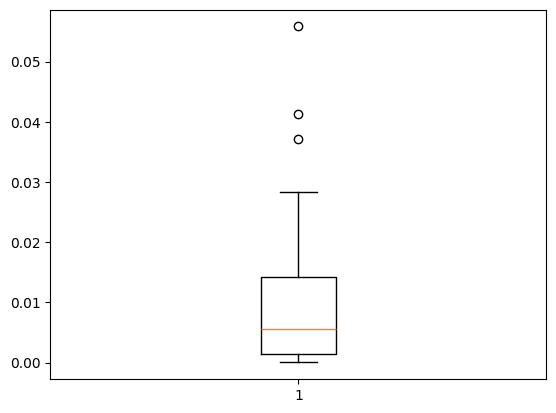

In [9]:
plt.boxplot(np.abs(prms_df['mean_z']-prms_df['t0']));

In [10]:
prms_df

,sbj,b0,lambda,delta0,delta1,t0,sigma,mean_z,std_z,G2,BIC
0,S10_epo,0.695954,0.010000,3.843673,0.709092,0.325574,0.325281,0.319898,0.106723,-716.035097,-678.132109
1,S11_epo,0.987948,0.010000,2.948183,0.599257,0.421046,0.297375,0.449453,0.136271,749.709665,787.547316
2,S12_epo,0.760386,0.010000,2.103449,0.324457,0.357535,0.352699,0.353560,0.120731,-133.530889,-95.606280
3,S13_epo,1.433412,0.348413,4.332841,0.772856,0.388528,0.340485,0.388495,0.143507,-177.232658,-139.286504
4,S14_epo,1.026522,0.021269,3.851520,0.658493,0.340639,0.314062,0.333461,0.108337,-409.672594,-371.758785
5,S15_epo,1.067700,0.072888,3.795592,0.801801,0.400892,0.326152,0.406285,0.143829,467.651479,505.500070
6,S16_epo,1.334728,0.268668,4.516416,0.961128,0.357055,0.304004,0.356035,0.116580,87.514887,125.428695
7,S17_epo,1.591732,0.119833,2.491738,0.484520,0.424082,0.399517,0.432050,0.181177,926.940476,963.110147
8,S18_epo,0.644105,0.061671,2.587882,0.469481,0.325781,0.384597,0.314731,0.109754,-437.763438,-399.828047
9,S19_epo,0.874766,0.010000,2.395424,0.425205,0.350836,0.351661,0.387898,0.144513,450.600593,488.471002


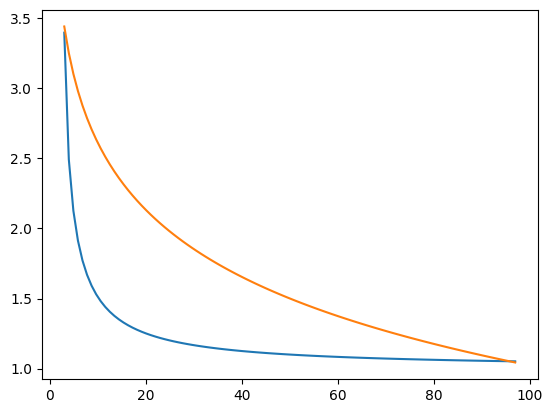

In [33]:
x = np.linspace(3, 97, 100)

plt.plot(x, 1 - np.log((x-2.5)/(x+2.5)))
plt.plot(x, 4.2 - .69*np.log(x))